In [1]:
import matplotlib.pyplot as plt
import pydicom
import pydicom.data
from pydicom.pixel_data_handlers.util import apply_voi_lut, apply_color_lut, apply_modality_lut

import gdcm #Для работы с DICOM-файлами, у которых было использовано сжатие массива пикселей

import cv2
from PIL import Image
import itertools
import pandas as pd
import numpy as np

from tqdm import tqdm
import tqdm.notebook as tqdm

import warnings
import os

from glob import glob

In [5]:
warnings.filterwarnings("ignore") # Игнорируем ошибки, чтобы они не забивали вывод

In [6]:
BATCH_SIZE = 16
IMAGE_SIZE = (180, 180)
BASE = r"M:\all_mosmed_datasets"

Загружаем разметку

In [7]:
data_1 = pd.read_excel(BASE+"/labels.xlsx")
data_2 = pd.read_excel(BASE+"/CT_OSTEOPOROZ_anon.xlsx")
data_3_selfmade = pd.read_excel(BASE+"/labels_selfmade_test.xlsx")
dataframes = [data_1, data_3_selfmade, data_2]
data_total = pd.concat(dataframes)
data_total

study_instance_anon  pathology
0  1.2.643.5.1.13.13.12.2.77.8252.081313020013031...          1
1  1.2.643.5.1.13.13.12.2.77.8252.110000131504120...          1
2  1.2.643.5.1.13.13.12.2.77.8252.141010110508051...          1
3  1.2.643.5.1.13.13.12.2.77.8252.010600140113071...          1
4  1.2.643.5.1.13.13.12.2.77.8252.150210040302150...          0
5  1.2.643.5.1.13.13.12.2.77.8252.121301120011090...          1
0  1.2.392.200036.9116.2.5.1.37.2424230430.157861...          0
1  1.2.840.113619.2.337.3.2831155466.548.15832935...          0
0  1.2.643.5.1.13.13.12.2.77.8252.071101121414120...          0
1  1.2.643.5.1.13.13.12.2.77.8252.001408080510061...          1
2  1.2.643.5.1.13.13.12.2.77.8252.090914150300070...          0
3  1.2.643.5.1.13.13.12.2.77.8252.090008150710100...          1
4  1.2.643.5.1.13.13.12.2.77.8252.080303010414010...          1
5  1.2.643.5.1.13.13.12.2.77.8252.031002101310030...          0
6  1.2.643.5.1.13.13.12.2.77.8252.031512030707151...          1
7  1.2.643.5.1.13.13.12.2.77.8252.110204060906021...          0

In [8]:
# Названия записей КТ-исследований, отдельно с патологией и без
patients_pathologies = data_total.loc[data_total.pathology == 1] .study_instance_anon.tolist()
patients_normals = data_total.loc[data_total.pathology == 0] .study_instance_anon.tolist()

In [9]:
# Создадим словари с названиями серий к каждой записи КТ-исследования
patients_dict = {}
for patient in patients_pathologies+patients_normals:
    patients_dict[patient] = os.listdir(BASE+'/'+patient)

In [10]:
def show_dcm_images(path_folder, rows=4, cols=8, random=0):
    #Вывод .dcm изображений по их расположению в пространстве
    
    N = rows*cols

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24,15))

    # Получаем пути к .dcm файлам
    dcm_paths = glob(f"{path_folder}/*")
    print("ОБЩЕЕ кол-во снимков:", len(dcm_paths)) # Под снимками подразумеваются СРЕЗЫ
    dcm_paths.sort()
    dcm_paths = dcm_paths[random:(random+N)]
    # Получаем серии КТ-снимков (срезов)
    datasets = [pydicom.dcmread(path) for path in dcm_paths]
    # Изменяем яркость и контрастность снимков (срезов) при помощи apply_voi_lut. Кости становятся видны лучше.
    images = [apply_voi_lut(dataset.pixel_array, dataset) for dataset in datasets]

    # Достаем наши изображения
    for data, img, i in zip(datasets, images, range(N)):
        slice_no = data.SliceLocation

        # Размещаем изображения по строкам и столбцам
        x = i // cols
        y = i % cols

        axes[x, y].imshow(img, cmap="bone")
        axes[x, y].set_title(f"Снимок: {slice_no}", 
                  fontsize=14, weight='bold')
        axes[x, y].axis('off')
        

Выведем примеры представления КТ-снимков

ОБЩЕЕ кол-во снимков: 342


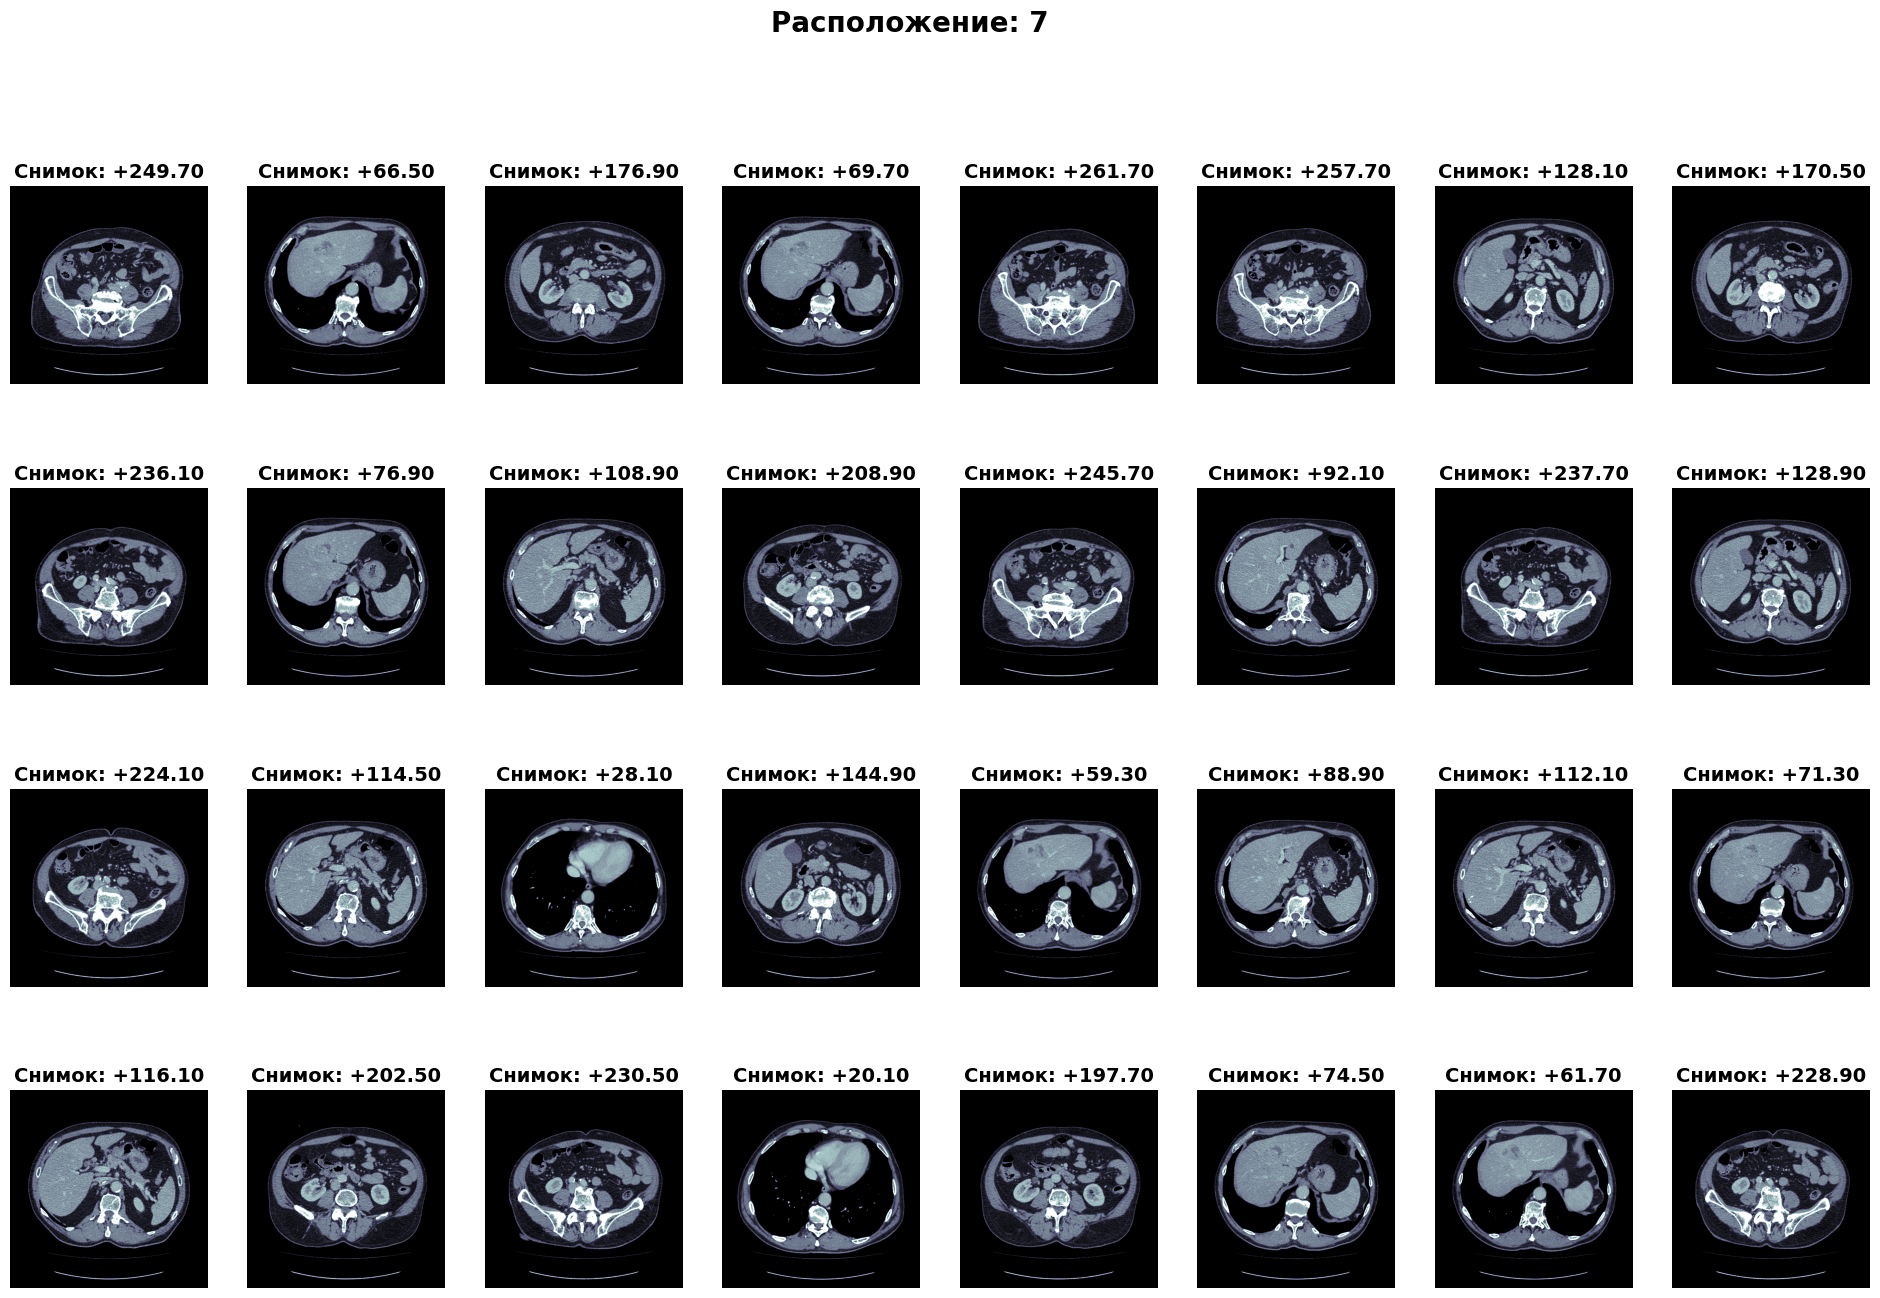

In [11]:
#Примеры снимков с патологией
show_dcm_images(BASE+'/'+patients_pathologies[0] + '/' + patients_dict[patients_pathologies[0]][0],
                rows=4, cols=8)

ОБЩЕЕ кол-во снимков: 369


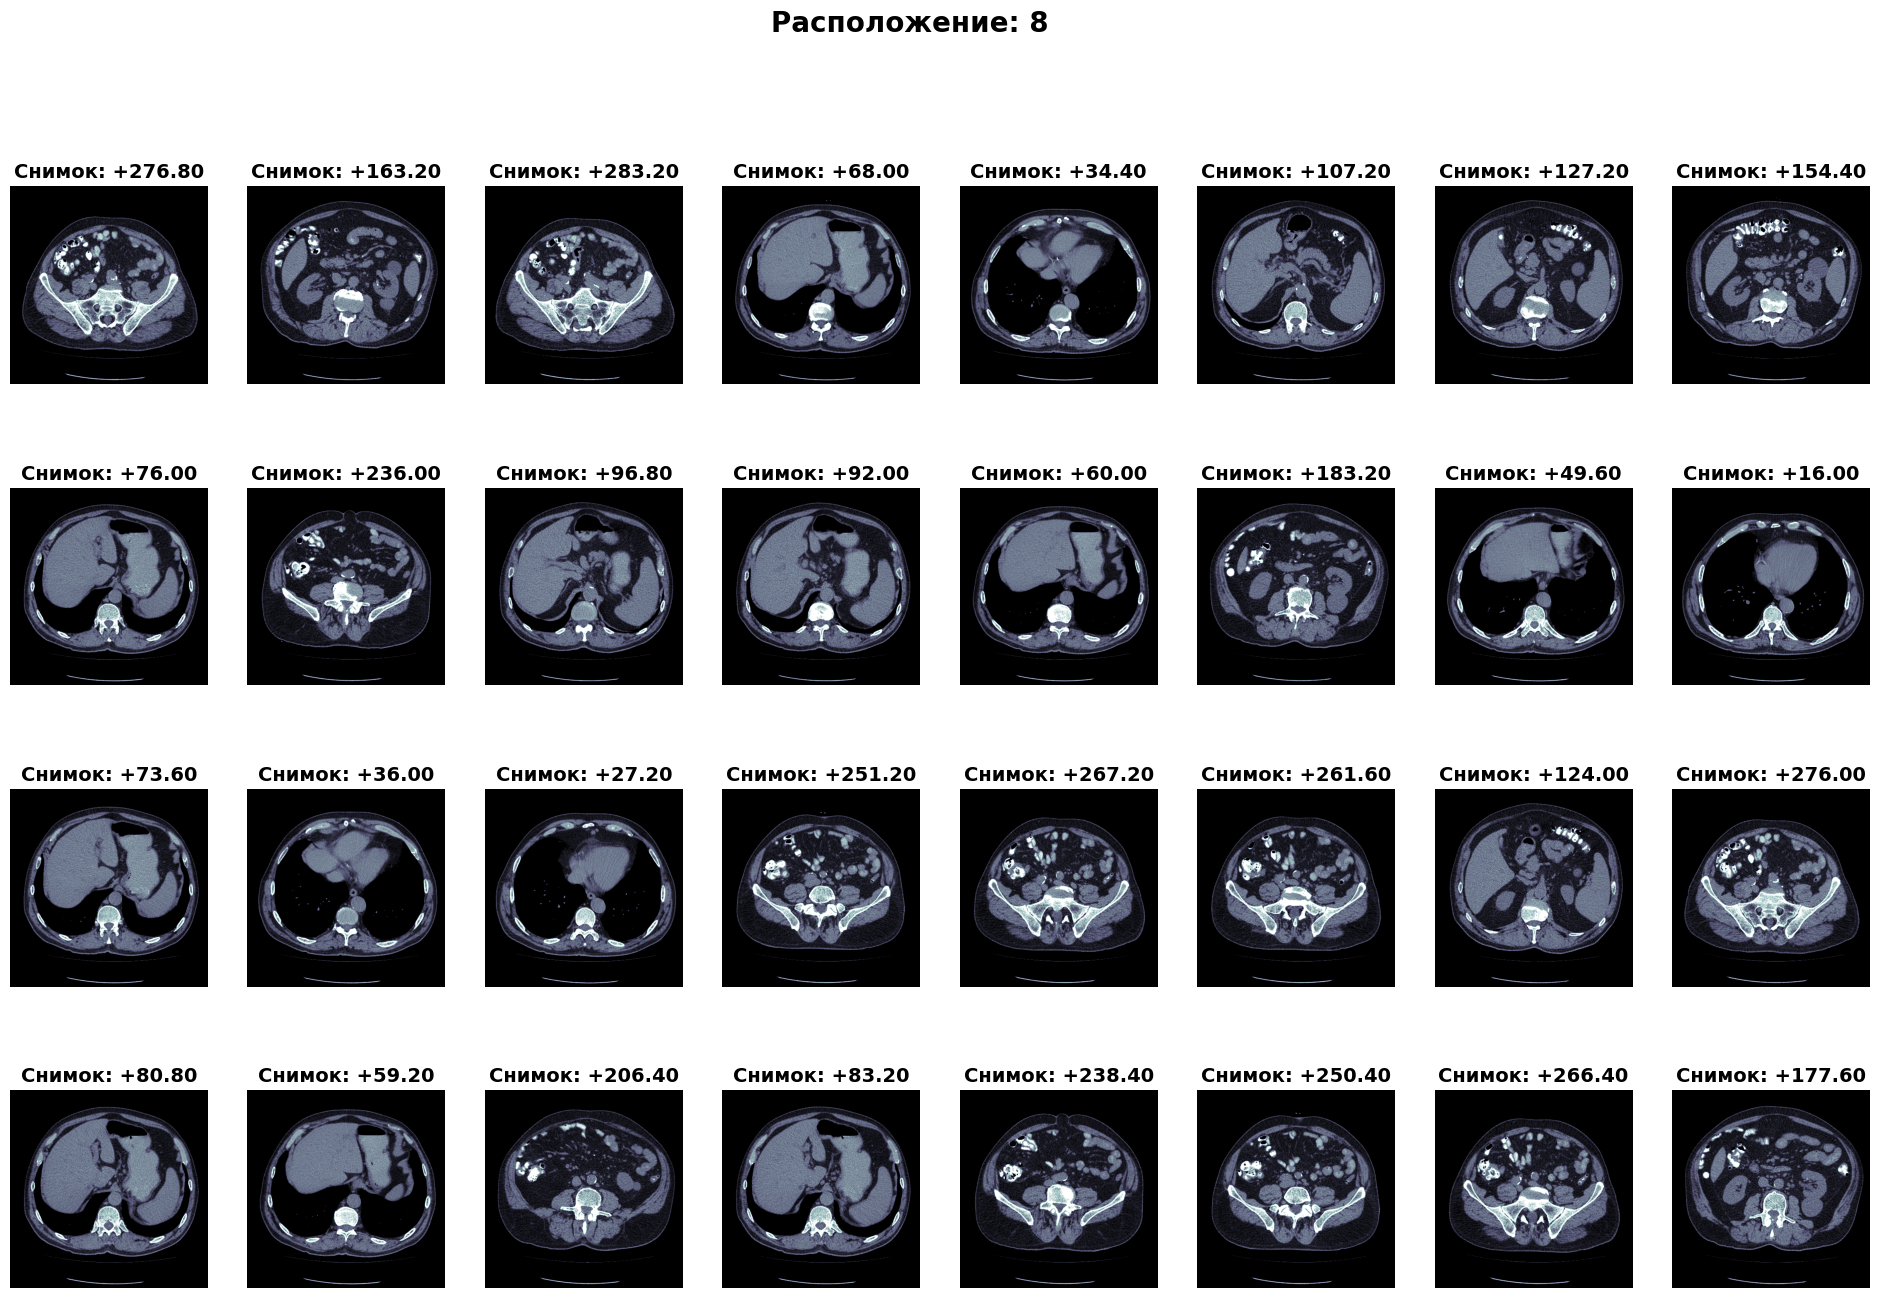

In [12]:
#Примеры снимков без патологии
show_dcm_images(BASE+'/'+patients_normals[0] + '/' + patients_dict[patients_normals[0]][0],
                rows=4, cols=8)

Вывод нескольких проекций

In [68]:
#Получение серии снимков из указанной директории
def get_dcm_serie(path_to_dcm_serie : str):
    ds_list = []
    dcm_files = os.listdir(path_to_dcm_serie)
    for file in dcm_files:
        buf_ds_file = pydicom.dcmread(path_to_dcm_serie+'/'+file)
        #Проверяем, аксиальная ли проекция у снимка (иногда в датасетах появляются сагитальные и корональные снимки)
        if ("ImageType" in buf_ds_file) == False:
            ds_list.append(buf_ds_file)
        elif buf_ds_file.ImageType[-1] == 'AXIAL':
            ds_list.append(buf_ds_file)
    print(f'Кол-во снимков = {len(ds_list)}')
    return ds_list

In [63]:
# Функция для вывода нескольких проекций (аксиальной, сагитальной, корональной)
def get_proections(ds_list):
    ds_list = sorted(ds_list, key=lambda s: s.ImagePositionPatient[2])

    # Проверяем, что все срезы имеют одинаковые характеристики
    ps = ds_list[0].PixelSpacing
    ss = ds_list[0].SliceThickness
    ax_aspect = ps[1]/ps[0]
    sag_aspect = ps[1]/ss
    cor_aspect = ss/ps[0]

    # Создаем трехмерный массив
    img_shape = list(ds_list[0].pixel_array.shape)
    img_shape.append(len(ds_list))
    img3d=np.zeros(img_shape)
    #print(ds_list[0].pixel_array.shape)

    # Заполняем трехмерный массив нашими снимками (срезами), увеличивая при этом их контрастность
    for i, s in enumerate(ds_list):
        img2d = apply_voi_lut(s.pixel_array, s)
        img3d[:,:,i] = img2d

    # АКСИАЛЬНАЯ ПРОЕКЦИЯ
    a1 = plt.subplot(1,3, 1)
    a1.set_title('Аксиальная', fontsize=14, fontweight='bold')
    a1.axis('off')
    plt.imshow(img3d[:,:,img_shape[2]//2], cmap = 'bone')
    a1.set_aspect(ax_aspect)

    # САГИТАЛЬНАЯ ПРОЕКЦИЯ
    a2 = plt.subplot(1,3, 2)
    a2.set_title('Сагитальная', fontsize=14, fontweight='bold')
    a2.axis('off')
    plt.imshow(img3d[:,img_shape[1]//2,:], cmap = 'bone')
    a2.set_aspect(sag_aspect)

    # КОРОНАЛЬНАЯ ПРОЕКЦИЯ
    a3 = plt.subplot(1,3, 3)
    a3.set_title('Корональная', fontsize=14, fontweight='bold')
    a3.axis('off')
    plt.imshow(img3d[img_shape[0]//2,:,:].T, cmap = 'bone')
    a3.set_aspect(cor_aspect)

    plt.suptitle('Проекции')
    plt.tight_layout()
    plt.show()

471
(512, 512)


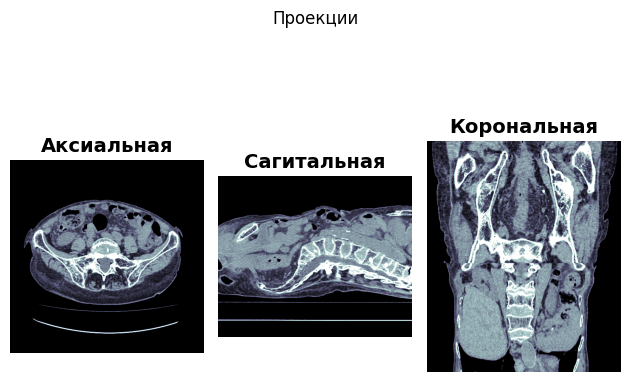

In [41]:
get_proections(get_dcm_serie(BASE+r"\1.2.643.5.1.13.13.12.2.77.8252.12130112001109041102110113101410\1.2.643.5.1.13.13.12.2.77.8252.14131002131107100010090811080801"))

Увеличение контрастности и размеров изображений

In [10]:
#Функция, которая увличивает контрастность изображений (костная ткань становится видна лучше) и изменяет их размер
def resize_and_voi_lut(dcm_file):
    buf_pixel_array = apply_voi_lut(dcm_file.pixel_array, dcm_file)
    resized_array = cv2.resize(buf_pixel_array, IMAGE_SIZE, interpolation = cv2.INTER_NEAREST)
    return resized_array

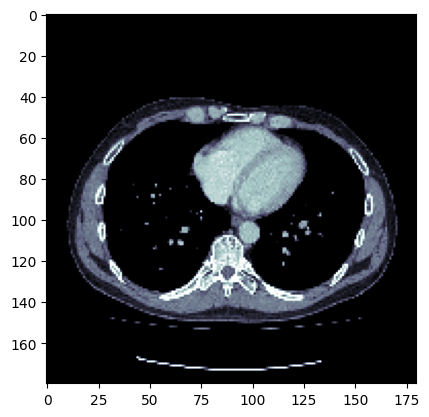

In [36]:
#Пример изображения после увеличения контрасности и изменения размера
plt.imshow(resize_and_voi_lut(pydicom.dcmread(r"M:\all_mosmed_datasets\CT_DS_III_Selftest_NADPOCH_anon\1.2.643.5.1.13.13.12.2.77.8252.00130608081015110208080502000610\1.2.643.5.1.13.13.12.2.77.8252.08070502060510101104020003120904\1.2.643.5.1.13.13.12.2.77.8252.04090709001013100001151003050900.dcm")), cmap='bone')
plt.show()

Часть с PyTorch'ем, подготовка данных для обучения, создание и обучение нейросети

In [11]:
# PyTorch
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms

import time
import copy

#Для аугментации
from scipy import ndimage
from random import randint

from sklearn.metrics import classification_report, confusion_matrix

Пробуем преобразовать КТ-серии в списки и затем в тензоры

In [12]:
# Создаем словарь, формата {название серии КТ-снимков : список КТ-снимков (изображений, двумерных массивов)}
def create_pixel_array_dictionary(name_in_dcm_sorted):
    base_path_to_sorted = BASE + '/' + name_in_dcm_sorted
    dcm_series = os.listdir(base_path_to_sorted)
    dcm_dict = {}
    #Обрабатываем только первую папку потому, что часто серии снимков копируют друг друга
    for dcm_serie in dcm_series[:1]:
        ds_list_sorted = []
        dcm_files_folder = base_path_to_sorted+'/'+dcm_serie
        dcm_files = os.listdir(dcm_files_folder)
        for file in dcm_files:
            buf_ds_file = pydicom.dcmread(dcm_files_folder+'/'+file)
            #ДЕЛАЕМ ПРОВЕРКУ, АКСИАЛЬНАЯ ЛИ ПРОЕКЦИЯ У СНИМКА
            if ("ImageType" in buf_ds_file) == False:
                ds_list_sorted.append(resize_and_voi_lut(buf_ds_file))
            elif buf_ds_file.ImageType[-1] == 'AXIAL':
                ds_list_sorted.append(resize_and_voi_lut(buf_ds_file))
        if len(ds_list_sorted) > 0:
            new_pair_dcm = [(dcm_serie, ds_list_sorted)]
            dcm_dict.update(new_pair_dcm)
    return dcm_dict

In [44]:
print(len(patients_pathologies))
print(len(patients_normals))

9
7


In [19]:
pathologies = []
normals = []
pathologies_test = []
normals_test = []
for name in patients_pathologies:
    created_pixel_array_dict = create_pixel_array_dictionary(name)
    for pixel_array in created_pixel_array_dict.values():
        for arr in pixel_array:
            if name == patients_pathologies[0]:
                pathologies_test.append(arr)
            else:
                pathologies.append(arr)
for name in patients_normals:
    created_pixel_array_dict = create_pixel_array_dictionary(name)
    for pixel_array in created_pixel_array_dict.values():
        for arr in pixel_array:
            if name == patients_normals[0]:
                normals_test.append(arr)
            else:
                normals.append(arr)

print('Кол-во снимков c признаками патологии: ',  len(pathologies))
print('Кол-во снимков без признаков патологии: ', len(normals))
print('Кол-во снимков для тестирования (каждого класса): ', min(len(pathologies_test), len(normals_test)))

Кол-во снимков с признаками патологии:  3616
Кол-во снимков без признаков патологии:  2229
Кол-во снимков для тестирования (каждого класса):  342


Аугментация (случайный поворот изображений в пределах 2 градусов)

In [20]:
def rotate_dataset(dataset):
    rotated_dataset = []
    for image in dataset:
        rotated_dataset.append(ndimage.rotate(image, randint(-2, 2), reshape=False))
    return rotated_dataset

In [23]:
# Получаем минимум из количеств снимков каждого класса, и исходя из этого отбираем изображения
target_count = min(len(normals), len(pathologies))

pathologies_x = pathologies[:target_count]

normals_x = normals[:target_count]

#Поворачиваем наши снимки на случайную градусную меру
pathologies_x = rotate_dataset(pathologies_x)
normals_x = rotate_dataset(normals_x)
print('Снимков каждого лейбла: ', len(pathologies_x))

Снимков каждого лейбла:  2229


In [200]:
#Создаем тензоры
my_x = np.array(pathologies_x + normals_x)
my_y = np.array([1 for i in range(len(pathologies_x))] + [0 for i in range(len(normals_x))])

#Нормализируем данные (значения от 0. до 1.)
my_x = (my_x - my_x.min()) / (my_x.max() - my_x.min())

idx = np.random.permutation(len(my_x)) #Перемешка
my_x, my_y = my_x[idx], my_y[idx]

tensor_x = torch.Tensor(my_x)
tensor_y = torch.Tensor(my_y)

Создаем класс для датасета, чтобы использовать в DataLoader'e, при разделении данных и при обучении нейронной сети

In [28]:
class MyDataSet(): 
  
    def __init__(self, x_tensor, y_tensor): 
        self.x = x_tensor
        self.y = y_tensor
        self.n_samples = len(x_tensor)

      
    def __getitem__(self, index): 
        return self.x[index], self.y[index] 
        
    # Чтобы можно было использовать len(dataset) для получения размера
    def __len__(self): 
        return self.n_samples 

In [224]:
def load_split_train_val(valid_size = .2):
    # Создаем экземпляр класса MyDataSet, с нашими данными для обучения
    dataset = MyDataSet(tensor_x, tensor_y)
    # Разделение данных на обучающую и валидационную выборки
    split_size = int(len(dataset)*(1-valid_size))
    train_data = list(dataset)[:split_size]
    val_data = list(dataset)[split_size:]
    train_idx, test_idx = len(train_data), len(val_data)
    dataset_size = {"train":train_idx, "val":test_idx}
    trainloader = DataLoader(train_data,
batch_size=BATCH_SIZE, shuffle=True)
    testloader = DataLoader(val_data,
batch_size=BATCH_SIZE, shuffle=True)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_val(.15)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}

Выбор устройства, на котором будет происходить обучение: Процессор или видеокарта.

In [24]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Выбран ГПУ")
else:
    device = torch.device("cpu")
    print("Выбран процессор")
# Моя видеокарта - RTX 3070. 5888 CUDA-ядер
# Мой процессор - Xeon e5 2689. 8 ядер, 16 потоков, частота 3.3 ГГц
# Обучение все разы проводил на видеокарте. 
# По данным tqdm, обучение на видеокарте примерно в 9 раз быстрее, чем на процессоре (в моем случае)

Выбран ГПУ


Создание модели нейросети, базирующейся на предобученной нейросети Densenet-121

In [226]:
def CNN_Model(pretrained=True):
    if pretrained:
        # Получаем предобученную сверточную нейронную сеть "DenseNet121" со стандартными весами
        model = torchvision.models.densenet121(torchvision.models.DenseNet121_Weights.DEFAULT)
    else:
        # Получаем готовую, но не необученную сверточную нейронную сеть "DenseNet121"
        model = torchvision.models.densenet121()
    # Получаем число признаков на выходном слое нейронной
    num_ftrs = model.classifier.in_features
    # Изменим слой классификации. Добавим дропаут для борьбы с переобучением нейросети и выход на 2 нейрона (т.к. 2 класса)
    model.classifier = nn.Sequential(nn.Dropout(0.1), nn.Linear(num_ftrs, 2))
    # Перемещаем нашу модель на используемое устройство
    model = model.to(device) 
    return model

model = CNN_Model(pretrained=False)

# Указываем функцию потерь
criterion = nn.CrossEntropyLoss()

# Указываем оптимизатор (лучше всех себя показали оптимизаторы Adam и Adamax)
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.Adamax(model.parameters(), lr=1e-3)

# Регуляризатор скорости обучения модели (уменьшаем скорость обучения модели на 0.15 каждые 7 эпох)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.15)

In [227]:
print(model) # Структура нейросети

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [228]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Кол-во обучаемых параметров: \n{}".format(pytorch_total_params))

Кол-во обучаемых параметров: 
6955906


In [229]:
import tqdm.notebook as tqdm

val_losses = []
train_losses = []
val_accuracies = [] 
train_accuracies = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Эпоха {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # В каждой эпохе есть две фазы - обучение и валидация
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Обучаем модель (меняем веса)
            else:
                model.eval()   # Тестируем модель
            current_loss = 0.0
            current_corrects = 0
            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                labels = labels.type('torch.LongTensor') # Чтобы числа в тензорах умещались
                inputs = inputs.to(device)
                labels = labels.to(device)

                #Корректируем размеры входных массивов, в данном случае до (batch_size, 3, IMAGE_SIZE)
                inputs = inputs.unsqueeze(1)
                inputs = torch.cat((inputs, inputs, inputs), 1)

                # Зануляем градиенты в кэше
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Только при обучении выполняем обратное распространение ошибки и инициализируем функцию потерь
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # Обрабатываем данные о потерях, чтобы можно было их сохранять для дальнейшего анализа
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} '.format(
                    phase, epoch_loss, phase, epoch_acc))
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu())
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu())

            # Сохранение весов, если уменьшился Loss на валидации
            if phase == 'val' and epoch_loss < best_loss:
                print('Loss уменьшился с {:.4f} до {:.4f} \nСохраняем веса... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Обучение закончилось за {:.0f}минут {:.0f}секунд'.format(
        time_since // 60, time_since % 60))
    print('Лучший Loss: {:.4f}'.format(best_loss))

    # Загрузим лучшие сохраненные веса и вернем модель именно с ними
    model.load_state_dict(best_model_wts)
    return model

Обучение модели

In [234]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=201)

Эпоха 1/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2907 | train Accuracy: 0.8845


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2727 | val Accuracy: 0.8848 
Loss уменьшился с inf до 0.2727 
Сохраняем веса... 

Эпоха 2/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.3034 | train Accuracy: 0.8782


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2774 | val Accuracy: 0.8883 

Эпоха 3/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2938 | train Accuracy: 0.8833


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2707 | val Accuracy: 0.8860 
Loss уменьшился с 0.2727 до 0.2707 
Сохраняем веса... 

Эпоха 4/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2938 | train Accuracy: 0.8806


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2734 | val Accuracy: 0.8848 

Эпоха 5/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2918 | train Accuracy: 0.8804


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2712 | val Accuracy: 0.8826 

Эпоха 6/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2928 | train Accuracy: 0.8788


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2730 | val Accuracy: 0.8860 

Эпоха 7/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2907 | train Accuracy: 0.8835


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2740 | val Accuracy: 0.8848 

Эпоха 8/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2950 | train Accuracy: 0.8786


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2751 | val Accuracy: 0.8837 

Эпоха 9/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2971 | train Accuracy: 0.8818


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2708 | val Accuracy: 0.8814 

Эпоха 10/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2919 | train Accuracy: 0.8837


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2724 | val Accuracy: 0.8860 

Эпоха 11/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2954 | train Accuracy: 0.8804


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2730 | val Accuracy: 0.8791 

Эпоха 12/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2935 | train Accuracy: 0.8804


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2723 | val Accuracy: 0.8883 

Эпоха 13/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2965 | train Accuracy: 0.8820


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2718 | val Accuracy: 0.8883 

Эпоха 14/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2863 | train Accuracy: 0.8851


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2709 | val Accuracy: 0.8837 

Эпоха 15/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2923 | train Accuracy: 0.8796


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2774 | val Accuracy: 0.8837 

Эпоха 16/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2958 | train Accuracy: 0.8810


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2703 | val Accuracy: 0.8803 
Loss уменьшился с 0.2707 до 0.2703 
Сохраняем веса... 

Эпоха 17/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2915 | train Accuracy: 0.8804


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2726 | val Accuracy: 0.8860 

Эпоха 18/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2879 | train Accuracy: 0.8855


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2801 | val Accuracy: 0.8848 

Эпоха 19/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2974 | train Accuracy: 0.8802


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2725 | val Accuracy: 0.8860 

Эпоха 20/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2928 | train Accuracy: 0.8802


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2727 | val Accuracy: 0.8860 

Эпоха 21/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2902 | train Accuracy: 0.8849


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2766 | val Accuracy: 0.8883 

Эпоха 22/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2932 | train Accuracy: 0.8824


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2706 | val Accuracy: 0.8826 

Эпоха 23/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2878 | train Accuracy: 0.8863


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2723 | val Accuracy: 0.8803 

Эпоха 24/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2915 | train Accuracy: 0.8800


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2711 | val Accuracy: 0.8871 

Эпоха 25/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2925 | train Accuracy: 0.8835


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2718 | val Accuracy: 0.8848 

Эпоха 26/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2962 | train Accuracy: 0.8788


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2755 | val Accuracy: 0.8848 

Эпоха 27/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2902 | train Accuracy: 0.8794


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2706 | val Accuracy: 0.8826 

Эпоха 28/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2913 | train Accuracy: 0.8829


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2742 | val Accuracy: 0.8860 

Эпоха 29/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2896 | train Accuracy: 0.8829


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2726 | val Accuracy: 0.8814 

Эпоха 30/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2995 | train Accuracy: 0.8792


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2740 | val Accuracy: 0.8837 

Эпоха 31/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2952 | train Accuracy: 0.8818


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2761 | val Accuracy: 0.8848 

Эпоха 32/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2993 | train Accuracy: 0.8814


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2733 | val Accuracy: 0.8860 

Эпоха 33/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2934 | train Accuracy: 0.8824


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2715 | val Accuracy: 0.8803 

Эпоха 34/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2939 | train Accuracy: 0.8802


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2710 | val Accuracy: 0.8871 

Эпоха 35/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2928 | train Accuracy: 0.8776


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2720 | val Accuracy: 0.8803 

Эпоха 36/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2944 | train Accuracy: 0.8794


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2706 | val Accuracy: 0.8826 

Эпоха 37/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2982 | train Accuracy: 0.8818


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2759 | val Accuracy: 0.8871 

Эпоха 38/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2941 | train Accuracy: 0.8808


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2720 | val Accuracy: 0.8848 

Эпоха 39/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2926 | train Accuracy: 0.8810


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2742 | val Accuracy: 0.8814 

Эпоха 40/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2909 | train Accuracy: 0.8831


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2724 | val Accuracy: 0.8848 

Эпоха 41/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2972 | train Accuracy: 0.8774


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2723 | val Accuracy: 0.8814 

Эпоха 42/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2941 | train Accuracy: 0.8790


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2725 | val Accuracy: 0.8837 

Эпоха 43/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2953 | train Accuracy: 0.8808


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2706 | val Accuracy: 0.8871 

Эпоха 44/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2943 | train Accuracy: 0.8780


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2704 | val Accuracy: 0.8848 

Эпоха 45/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2919 | train Accuracy: 0.8788


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2722 | val Accuracy: 0.8826 

Эпоха 46/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2939 | train Accuracy: 0.8770


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2716 | val Accuracy: 0.8837 

Эпоха 47/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2920 | train Accuracy: 0.8778


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2730 | val Accuracy: 0.8860 

Эпоха 48/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2882 | train Accuracy: 0.8835


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2707 | val Accuracy: 0.8837 

Эпоха 49/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2930 | train Accuracy: 0.8835


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2797 | val Accuracy: 0.8940 

Эпоха 50/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2952 | train Accuracy: 0.8810


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2734 | val Accuracy: 0.8860 

Эпоха 51/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2941 | train Accuracy: 0.8776


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2715 | val Accuracy: 0.8871 

Эпоха 52/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2922 | train Accuracy: 0.8786


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2711 | val Accuracy: 0.8826 

Эпоха 53/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2944 | train Accuracy: 0.8780


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2711 | val Accuracy: 0.8814 

Эпоха 54/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2895 | train Accuracy: 0.8820


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2718 | val Accuracy: 0.8860 

Эпоха 55/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2948 | train Accuracy: 0.8843


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2752 | val Accuracy: 0.8848 

Эпоха 56/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2920 | train Accuracy: 0.8810


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2720 | val Accuracy: 0.8826 

Эпоха 57/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.3015 | train Accuracy: 0.8806


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2716 | val Accuracy: 0.8883 

Эпоха 58/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2911 | train Accuracy: 0.8808


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2814 | val Accuracy: 0.8883 

Эпоха 59/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2891 | train Accuracy: 0.8831


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2731 | val Accuracy: 0.8837 

Эпоха 60/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2966 | train Accuracy: 0.8798


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2765 | val Accuracy: 0.8826 

Эпоха 61/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2888 | train Accuracy: 0.8816


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2752 | val Accuracy: 0.8837 

Эпоха 62/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2948 | train Accuracy: 0.8812


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2722 | val Accuracy: 0.8826 

Эпоха 63/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2943 | train Accuracy: 0.8814


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2721 | val Accuracy: 0.8837 

Эпоха 64/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2958 | train Accuracy: 0.8808


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2729 | val Accuracy: 0.8848 

Эпоха 65/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2938 | train Accuracy: 0.8831


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2809 | val Accuracy: 0.8848 

Эпоха 66/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2918 | train Accuracy: 0.8865


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2724 | val Accuracy: 0.8894 

Эпоха 67/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2872 | train Accuracy: 0.8820


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2710 | val Accuracy: 0.8803 

Эпоха 68/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2971 | train Accuracy: 0.8796


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2731 | val Accuracy: 0.8814 

Эпоха 69/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2914 | train Accuracy: 0.8796


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2723 | val Accuracy: 0.8814 

Эпоха 70/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2941 | train Accuracy: 0.8822


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2734 | val Accuracy: 0.8860 

Эпоха 71/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2981 | train Accuracy: 0.8804


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2719 | val Accuracy: 0.8826 

Эпоха 72/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2946 | train Accuracy: 0.8826


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2795 | val Accuracy: 0.8860 

Эпоха 73/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2897 | train Accuracy: 0.8851


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2743 | val Accuracy: 0.8894 

Эпоха 74/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2955 | train Accuracy: 0.8790


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2701 | val Accuracy: 0.8826 
Loss уменьшился с 0.2703 до 0.2701 
Сохраняем веса... 

Эпоха 75/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2922 | train Accuracy: 0.8822


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2726 | val Accuracy: 0.8871 

Эпоха 76/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2893 | train Accuracy: 0.8810


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2756 | val Accuracy: 0.8883 

Эпоха 77/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2908 | train Accuracy: 0.8814


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2722 | val Accuracy: 0.8826 

Эпоха 78/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2995 | train Accuracy: 0.8814


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2710 | val Accuracy: 0.8814 

Эпоха 79/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2957 | train Accuracy: 0.8784


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2727 | val Accuracy: 0.8837 

Эпоха 80/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2891 | train Accuracy: 0.8833


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2717 | val Accuracy: 0.8848 

Эпоха 81/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2923 | train Accuracy: 0.8826


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2702 | val Accuracy: 0.8814 

Эпоха 82/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2958 | train Accuracy: 0.8766


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2707 | val Accuracy: 0.8826 

Эпоха 83/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2957 | train Accuracy: 0.8826


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2729 | val Accuracy: 0.8848 

Эпоха 84/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2976 | train Accuracy: 0.8794


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2709 | val Accuracy: 0.8826 

Эпоха 85/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2954 | train Accuracy: 0.8810


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2715 | val Accuracy: 0.8848 

Эпоха 86/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2914 | train Accuracy: 0.8816


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2725 | val Accuracy: 0.8883 

Эпоха 87/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2924 | train Accuracy: 0.8778


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2711 | val Accuracy: 0.8860 

Эпоха 88/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2888 | train Accuracy: 0.8833


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2752 | val Accuracy: 0.8871 

Эпоха 89/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2944 | train Accuracy: 0.8822


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2744 | val Accuracy: 0.8837 

Эпоха 90/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2949 | train Accuracy: 0.8804


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2747 | val Accuracy: 0.8837 

Эпоха 91/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2920 | train Accuracy: 0.8814


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2728 | val Accuracy: 0.8837 

Эпоха 92/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.3011 | train Accuracy: 0.8770


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2787 | val Accuracy: 0.8848 

Эпоха 93/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2932 | train Accuracy: 0.8839


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2723 | val Accuracy: 0.8826 

Эпоха 94/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2960 | train Accuracy: 0.8837


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2731 | val Accuracy: 0.8814 

Эпоха 95/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2905 | train Accuracy: 0.8826


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2720 | val Accuracy: 0.8837 

Эпоха 96/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2899 | train Accuracy: 0.8829


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2707 | val Accuracy: 0.8848 

Эпоха 97/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2956 | train Accuracy: 0.8812


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2744 | val Accuracy: 0.8871 

Эпоха 98/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2984 | train Accuracy: 0.8843


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2733 | val Accuracy: 0.8826 

Эпоха 99/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2929 | train Accuracy: 0.8788


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2733 | val Accuracy: 0.8883 

Эпоха 100/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2946 | train Accuracy: 0.8796


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2781 | val Accuracy: 0.8905 

Эпоха 101/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2951 | train Accuracy: 0.8802


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2728 | val Accuracy: 0.8826 

Эпоха 102/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2920 | train Accuracy: 0.8851


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2742 | val Accuracy: 0.8837 

Эпоха 103/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2922 | train Accuracy: 0.8796


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2714 | val Accuracy: 0.8757 

Эпоха 104/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2931 | train Accuracy: 0.8810


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2736 | val Accuracy: 0.8848 

Эпоха 105/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2900 | train Accuracy: 0.8843


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2715 | val Accuracy: 0.8848 

Эпоха 106/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2951 | train Accuracy: 0.8824


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2713 | val Accuracy: 0.8814 

Эпоха 107/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2951 | train Accuracy: 0.8812


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2712 | val Accuracy: 0.8894 

Эпоха 108/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2890 | train Accuracy: 0.8818


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2772 | val Accuracy: 0.8871 

Эпоха 109/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.3020 | train Accuracy: 0.8786


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2716 | val Accuracy: 0.8826 

Эпоха 110/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2966 | train Accuracy: 0.8778


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2714 | val Accuracy: 0.8837 

Эпоха 111/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2934 | train Accuracy: 0.8814


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2702 | val Accuracy: 0.8848 

Эпоха 112/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.3019 | train Accuracy: 0.8756


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2719 | val Accuracy: 0.8814 

Эпоха 113/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2950 | train Accuracy: 0.8774


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2710 | val Accuracy: 0.8803 

Эпоха 114/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2944 | train Accuracy: 0.8820


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2716 | val Accuracy: 0.8791 

Эпоха 115/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2929 | train Accuracy: 0.8790


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2717 | val Accuracy: 0.8848 

Эпоха 116/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2954 | train Accuracy: 0.8798


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2706 | val Accuracy: 0.8860 

Эпоха 117/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2916 | train Accuracy: 0.8820


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2714 | val Accuracy: 0.8803 

Эпоха 118/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2973 | train Accuracy: 0.8800


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2726 | val Accuracy: 0.8871 

Эпоха 119/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2914 | train Accuracy: 0.8847


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2706 | val Accuracy: 0.8826 

Эпоха 120/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2878 | train Accuracy: 0.8804


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2764 | val Accuracy: 0.8814 

Эпоха 121/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2913 | train Accuracy: 0.8808


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2728 | val Accuracy: 0.8826 

Эпоха 122/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2955 | train Accuracy: 0.8796


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2747 | val Accuracy: 0.8860 

Эпоха 123/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.3001 | train Accuracy: 0.8762


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2713 | val Accuracy: 0.8848 

Эпоха 124/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2889 | train Accuracy: 0.8824


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2728 | val Accuracy: 0.8803 

Эпоха 125/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2924 | train Accuracy: 0.8808


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2730 | val Accuracy: 0.8837 

Эпоха 126/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2932 | train Accuracy: 0.8758


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2767 | val Accuracy: 0.8837 

Эпоха 127/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2989 | train Accuracy: 0.8808


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2714 | val Accuracy: 0.8860 

Эпоха 128/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2902 | train Accuracy: 0.8855


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2731 | val Accuracy: 0.8814 

Эпоха 129/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2906 | train Accuracy: 0.8818


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2728 | val Accuracy: 0.8848 

Эпоха 130/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2926 | train Accuracy: 0.8851


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2727 | val Accuracy: 0.8826 

Эпоха 131/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2905 | train Accuracy: 0.8831


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2709 | val Accuracy: 0.8826 

Эпоха 132/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2916 | train Accuracy: 0.8814


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2727 | val Accuracy: 0.8814 

Эпоха 133/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2903 | train Accuracy: 0.8829


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2728 | val Accuracy: 0.8803 

Эпоха 134/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2950 | train Accuracy: 0.8770


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2711 | val Accuracy: 0.8803 

Эпоха 135/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2886 | train Accuracy: 0.8806


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2742 | val Accuracy: 0.8837 

Эпоха 136/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2931 | train Accuracy: 0.8808


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2725 | val Accuracy: 0.8803 

Эпоха 137/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2903 | train Accuracy: 0.8824


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2750 | val Accuracy: 0.8883 

Эпоха 138/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2844 | train Accuracy: 0.8837


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2727 | val Accuracy: 0.8848 

Эпоха 139/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2898 | train Accuracy: 0.8833


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2740 | val Accuracy: 0.8826 

Эпоха 140/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2952 | train Accuracy: 0.8814


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2720 | val Accuracy: 0.8780 

Эпоха 141/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2961 | train Accuracy: 0.8786


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2733 | val Accuracy: 0.8814 

Эпоха 142/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2952 | train Accuracy: 0.8833


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2722 | val Accuracy: 0.8814 

Эпоха 143/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2951 | train Accuracy: 0.8776


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2742 | val Accuracy: 0.8848 

Эпоха 144/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2928 | train Accuracy: 0.8843


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2712 | val Accuracy: 0.8814 

Эпоха 145/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2926 | train Accuracy: 0.8814


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2734 | val Accuracy: 0.8905 

Эпоха 146/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2982 | train Accuracy: 0.8776


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2709 | val Accuracy: 0.8814 

Эпоха 147/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2864 | train Accuracy: 0.8831


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2751 | val Accuracy: 0.8848 

Эпоха 148/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.3006 | train Accuracy: 0.8812


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2706 | val Accuracy: 0.8848 

Эпоха 149/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2961 | train Accuracy: 0.8810


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2724 | val Accuracy: 0.8848 

Эпоха 150/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2908 | train Accuracy: 0.8812


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2711 | val Accuracy: 0.8814 

Эпоха 151/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2941 | train Accuracy: 0.8818


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2740 | val Accuracy: 0.8848 

Эпоха 152/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2960 | train Accuracy: 0.8788


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2717 | val Accuracy: 0.8791 

Эпоха 153/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2907 | train Accuracy: 0.8810


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2717 | val Accuracy: 0.8860 

Эпоха 154/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.3013 | train Accuracy: 0.8760


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2725 | val Accuracy: 0.8860 

Эпоха 155/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2948 | train Accuracy: 0.8826


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2725 | val Accuracy: 0.8837 

Эпоха 156/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2894 | train Accuracy: 0.8818


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2715 | val Accuracy: 0.8848 

Эпоха 157/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2928 | train Accuracy: 0.8814


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2744 | val Accuracy: 0.8837 

Эпоха 158/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2893 | train Accuracy: 0.8824


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2762 | val Accuracy: 0.8848 

Эпоха 159/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2917 | train Accuracy: 0.8792


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2765 | val Accuracy: 0.8883 

Эпоха 160/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2934 | train Accuracy: 0.8794


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2710 | val Accuracy: 0.8894 

Эпоха 161/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2932 | train Accuracy: 0.8810


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2731 | val Accuracy: 0.8883 

Эпоха 162/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2889 | train Accuracy: 0.8804


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2751 | val Accuracy: 0.8848 

Эпоха 163/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2918 | train Accuracy: 0.8818


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2745 | val Accuracy: 0.8826 

Эпоха 164/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2910 | train Accuracy: 0.8824


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2741 | val Accuracy: 0.8826 

Эпоха 165/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2999 | train Accuracy: 0.8760


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2730 | val Accuracy: 0.8860 

Эпоха 166/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2935 | train Accuracy: 0.8772


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2758 | val Accuracy: 0.8871 

Эпоха 167/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2913 | train Accuracy: 0.8804


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2731 | val Accuracy: 0.8814 

Эпоха 168/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2911 | train Accuracy: 0.8790


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2722 | val Accuracy: 0.8837 

Эпоха 169/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2881 | train Accuracy: 0.8855


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2700 | val Accuracy: 0.8871 
Loss уменьшился с 0.2701 до 0.2700 
Сохраняем веса... 

Эпоха 170/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2909 | train Accuracy: 0.8806


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2719 | val Accuracy: 0.8860 

Эпоха 171/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2887 | train Accuracy: 0.8822


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2725 | val Accuracy: 0.8837 

Эпоха 172/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2909 | train Accuracy: 0.8816


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2723 | val Accuracy: 0.8791 

Эпоха 173/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2954 | train Accuracy: 0.8808


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2738 | val Accuracy: 0.8746 

Эпоха 174/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2950 | train Accuracy: 0.8820


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2718 | val Accuracy: 0.8814 

Эпоха 175/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2892 | train Accuracy: 0.8814


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2732 | val Accuracy: 0.8814 

Эпоха 176/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2888 | train Accuracy: 0.8835


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2714 | val Accuracy: 0.8803 

Эпоха 177/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2928 | train Accuracy: 0.8794


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2717 | val Accuracy: 0.8826 

Эпоха 178/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2959 | train Accuracy: 0.8808


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2772 | val Accuracy: 0.8905 

Эпоха 179/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2912 | train Accuracy: 0.8788


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2718 | val Accuracy: 0.8837 

Эпоха 180/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2935 | train Accuracy: 0.8794


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2726 | val Accuracy: 0.8871 

Эпоха 181/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2915 | train Accuracy: 0.8818


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2726 | val Accuracy: 0.8837 

Эпоха 182/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2890 | train Accuracy: 0.8812


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2729 | val Accuracy: 0.8860 

Эпоха 183/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2990 | train Accuracy: 0.8778


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2715 | val Accuracy: 0.8814 

Эпоха 184/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2889 | train Accuracy: 0.8829


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2724 | val Accuracy: 0.8837 

Эпоха 185/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2993 | train Accuracy: 0.8796


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2730 | val Accuracy: 0.8848 

Эпоха 186/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2887 | train Accuracy: 0.8822


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2714 | val Accuracy: 0.8837 

Эпоха 187/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2947 | train Accuracy: 0.8820


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2718 | val Accuracy: 0.8871 

Эпоха 188/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2941 | train Accuracy: 0.8790


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2783 | val Accuracy: 0.8883 

Эпоха 189/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2911 | train Accuracy: 0.8831


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2725 | val Accuracy: 0.8837 

Эпоха 190/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2957 | train Accuracy: 0.8814


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2729 | val Accuracy: 0.8791 

Эпоха 191/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2888 | train Accuracy: 0.8786


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2747 | val Accuracy: 0.8837 

Эпоха 192/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2879 | train Accuracy: 0.8824


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2800 | val Accuracy: 0.8871 

Эпоха 193/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2959 | train Accuracy: 0.8835


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2726 | val Accuracy: 0.8860 

Эпоха 194/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2963 | train Accuracy: 0.8800


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2745 | val Accuracy: 0.8848 

Эпоха 195/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2942 | train Accuracy: 0.8772


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2702 | val Accuracy: 0.8837 

Эпоха 196/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2924 | train Accuracy: 0.8800


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2709 | val Accuracy: 0.8883 

Эпоха 197/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2917 | train Accuracy: 0.8808


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2727 | val Accuracy: 0.8848 

Эпоха 198/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2947 | train Accuracy: 0.8798


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2721 | val Accuracy: 0.8837 

Эпоха 199/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2910 | train Accuracy: 0.8820


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2713 | val Accuracy: 0.8860 

Эпоха 200/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2922 | train Accuracy: 0.8794


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2741 | val Accuracy: 0.8848 

Эпоха 201/201
----------


train:   0%|          | 0/156 [00:00<?, ?it/s]

train Loss: 0.2929 | train Accuracy: 0.8800


val:   0%|          | 0/28 [00:00<?, ?it/s]

val Loss: 0.2738 | val Accuracy: 0.8826 

Обучение закончилось за 104минут 40секунд
Лучший Loss: 0.2700


In [235]:
#Выгрузка мусора из памяти
import gc
gc.collect()
torch.cuda.empty_cache()

Вывод потерь и точности по эпохам

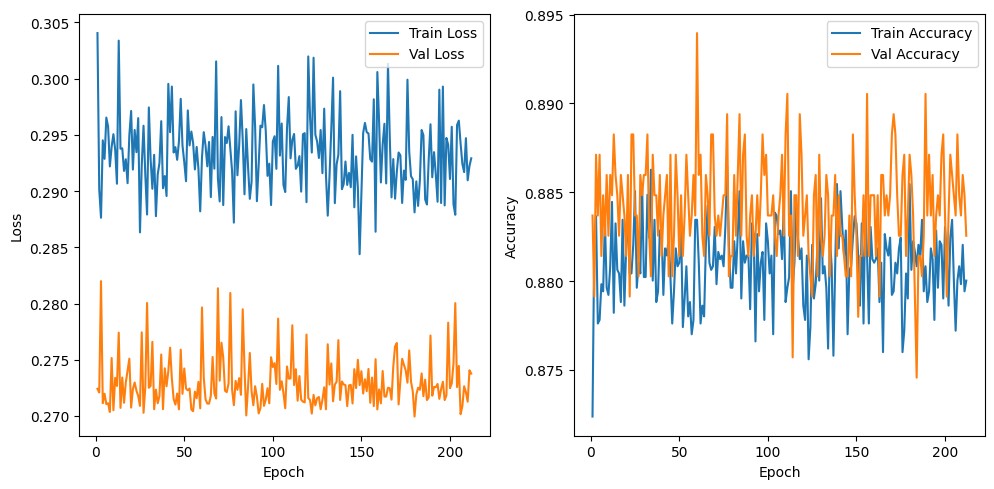

In [236]:
def plot_metrics(train_loss, train_acc, val_loss, val_acc):
    epochs = np.arange(1, len(train_loss) + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs[:len(val_loss)], val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs[:len(val_acc)], val_acc, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

Тестирование с выводом метрик

In [26]:
min_len = min(len(pathologies_test), len(normals_test))
print('Снимков каждого класса: ', min_len)

pathologies_test = pathologies_test[:min_len]
normals_test = normals_test[:min_len]

test_data = pathologies_test + normals_test


my_x_test = np.array(test_data)
my_y_test = np.array([1 for i in range(min_len)] + [0 for i in range(min_len)])


my_x_test = (my_x_test - my_x_test.min()) / (my_x_test.max() - my_x_test.min())

idx_test = np.random.permutation(len(my_x_test)) #Перемешка
my_x_test, my_y_test = my_x_test[idx_test], my_y_test[idx_test]



tensor_x_test = torch.Tensor(my_x_test)
tensor_y_test = torch.Tensor(my_y_test)

Снимков каждого класса:  342


In [29]:
test_data = list(MyDataSet(tensor_x_test, tensor_y_test))
testloader = DataLoader(test_data, batch_size=1)

Тестирование с выводом метрик

In [62]:
def get_predictions(dataloader):
    y_pred_list = []
    y_true_list = []

    with torch.no_grad():
        for x_batch, y_batch in tqdm.tqdm(dataloader, leave=False):
            x_batch = x_batch.unsqueeze(1)
            x_batch = torch.cat((x_batch, x_batch, x_batch), 1)
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_test_pred = base_model(x_batch)
            y_test_pred = torch.log_softmax(y_test_pred, dim=1)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(y_batch.cpu().numpy())

    return y_true_list, y_pred_list

y_true_list, y_pred_list = get_predictions(testloader)

print(classification_report(y_true_list, y_pred_list))

  0%|          | 0/684 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.98      0.75      0.85       342
         1.0       0.80      0.99      0.88       342

    accuracy                           0.87       684
   macro avg       0.89      0.87      0.86       684
weighted avg       0.89      0.87      0.86       684



Матрица ошибок

In [54]:
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

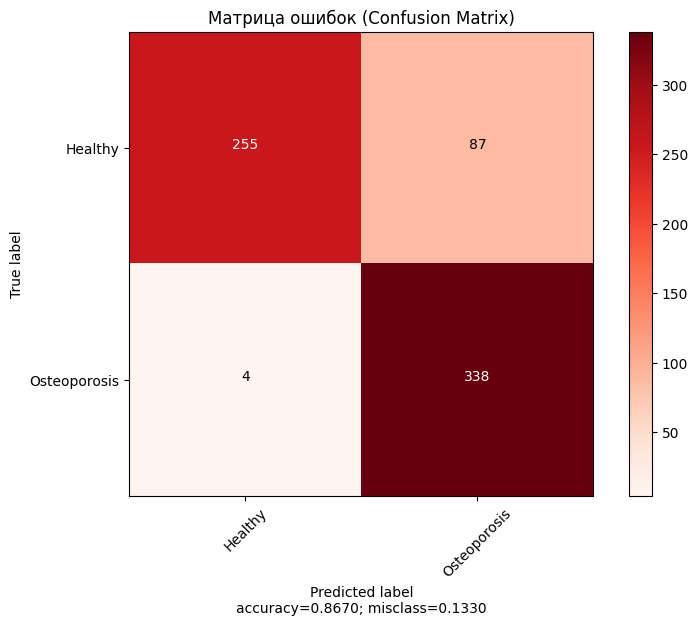

In [56]:
cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['Healthy','Osteoporosis'],
                      title        = "Матрица ошибок (Confusion Matrix)")

Сохранение модели, чтобы потом можно было использовать её без повторного обучения

In [33]:
from datetime import datetime
now = datetime.now()
additional_info = 'itog_201_epochs_86ac'
torch.save(base_model, r"M:\nn_models\test_"+f'{now.month}_{now.day}_{now.hour}_{now.minute}' +additional_info)

Черновой тест готовой модели на данных, которые модель не видела

In [39]:
def apply_voi_lut_array(ds_list):
    ds_list_lut = [resize_and_voi_lut(x) for x in ds_list]
    return ds_list_lut

In [71]:
def get_predict_for_lut_serie(ds_list_lut):
    pathologies_x_test = np.array(ds_list_lut)
    pathologies_x_test = (pathologies_x_test - pathologies_x_test.min()) / (pathologies_x_test.max() - pathologies_x_test.min())

    tensor_x_test = torch.Tensor(pathologies_x_test)

    buf_y = np.arange(1, len(tensor_x_test)+1, 1)
    buf_y_tensor = torch.Tensor(buf_y)

    test_data = list(MyDataSet(tensor_x_test, buf_y_tensor))
    testloader = DataLoader(test_data, batch_size=1)

    _, y_pred_list = get_predictions(testloader)
    y_pred_list = np.array(y_pred_list)

    print(f'Вероятность наличия остеопороза: {y_pred_list.mean()*100}%')

In [37]:
def get_predict_for_serie_path(path: str):
    dcm_serie = get_dcm_serie(path)
    get_proections(dcm_serie)
    dcm_serie = apply_voi_lut_array(dcm_serie)
    get_predict_for_lut_serie(dcm_serie)

Кол-во снимков = 416


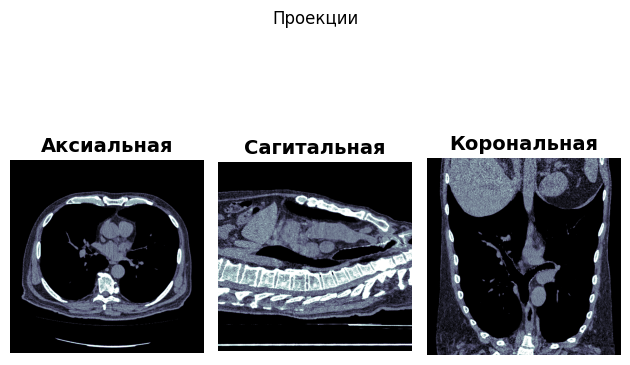

  0%|          | 0/416 [00:00<?, ?it/s]

Вероятность наличия остеопороза: 16.346153846153847%


In [72]:
get_predict_for_serie_path(r"C:\Users\apka2\Desktop\Студенчество\Курсач остеопороз\mosmed selftest\CT\Toshiba_Medical_Systems_Corporation_Aquilion_32\1.2.392.200036.9116.2.6.1.16.1613459359.1580260610.913128\1.2.392.200036.9116.2.6.1.16.1613459359.1580261709.829914")

Кол-во снимков = 401


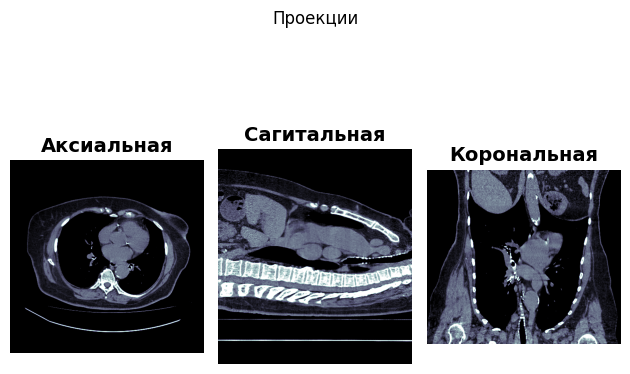

  0%|          | 0/401 [00:00<?, ?it/s]

Вероятность наличия остеопороза: 46.13466334164589%


In [73]:
get_predict_for_serie_path(r"C:\Users\apka2\Desktop\Студенчество\Курсач остеопороз\mosmed selftest\CT\Siemens_Somatom_Sensation_40\1.2.392.200036.9116.2.5.1.37.2420762535.1572499357.2397\1.2.392.200036.9116.2.5.1.37.2420762535.1572499540.173249")